masih ada duplikat di bulan 11/12

In [1]:
import utils
import pandas as pd
import calendar
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# 1
# open files
arr = utils.fileList("rsc/")
arr.sort()
lists = list()
unused_columns = ['nilai_kerugian',
'jumlah_tempat_pengungsian',
'jumlah_pengungsi_tertinggi',
'jumlah_luka_ringan',
'jumlah_luka_berat',
'jumlah_hilang',
'jumlah_meninggal',
'lama_genangan',
'ketinggian_air',
'jumlah_terdampak_jiwa',
'jumlah_terdampak_kk',
'jumlah_terdampak_rw',
'jumlah_terdampak_rt',
'rw']
for item in arr:
    csv = utils.readCsv("rsc/" + item)
    for unused in unused_columns:
        csv.drop(unused, axis=1, inplace=True)
    csv.drop_duplicates(subset=None, keep='first', inplace=False)
    lists.append(csv)


In [4]:
# 2
print(lists[0].columns)

Index(['kota_administrasi', 'kecamatan', 'kelurahan', 'tanggal_kejadian'], dtype='object')


In [5]:
# 3
nama_benahan = ["PULOGADUNG", "CILIINCING", "MAMPANG"]
for bulan in lists:
    for i in range(len(nama_benahan)):
        if i == 0:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "PULO GADUNG"
        elif i == 1:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "CILINCING"
        elif i == 2:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "MAMPANG PRAPATAN"

In [6]:
# 4
loc = [10,11]
for l in loc:
    rows = lists[l]['tanggal_kejadian']
    # print(type(rows), l)
    for row in rows:
        # print(type(row))
        # print(row)
        if "-" in row:
            # if isinstance(row, str):
            #     dd = row[-2:]
            # else:
            #     dd = row[-2:].copy()

            dd = str(row[-2:])
            # print(dd, type(dd))
            lists[l].loc[lists[l]['tanggal_kejadian'] == row, 'tanggal_kejadian'] = dd
        

In [7]:
# 5
# normalize table in tanggal_kejadian column
data_normaliasi_tanggal = list()
# re.search(r'[0-9]{2}, txt')

def ubah_format(kata : str) -> str:
    if len(kata) == 1:
        return "0"+kata
    else:
        return kata



for bulan in lists:
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].str.split(',')
    bulan = bulan.explode('tanggal_kejadian').reset_index(drop=True)
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.replace("tgl. ", ""))
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.lstrip()[:2])
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: ubah_format(kalimat))

    

    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.ljust(2, '0'))
    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat.string(): re.search(r'[0-9]{2}', kalimat))
    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].str.extract('(\d+)', expand=False)
    data_normaliasi_tanggal.append(bulan)


In [8]:
for bulan in data_normaliasi_tanggal:
    bulan.drop_duplicates()

In [9]:
# 6
# Membersihkan Data

for month in data_normaliasi_tanggal:
    length = len(month)
    last_kecamatan = ""
    last_kelurahan = ""

    i_container = []
    
    tanggal_container = []


    for i in range(length):
        if  i == 0:
            last_kecamatan = month.loc[i]["kecamatan"]
            last_kelurahan = month.loc[i]["kelurahan"]

            tanggal_container.append(month.loc[i]["tanggal_kejadian"])
            continue


        # Mendapatkan data terkini
        now_kecamatan = month.loc[i]["kecamatan"]
        now_kelurahan = month.loc[i]["kelurahan"]
        now_tanggal_kejadian = month.loc[i]["tanggal_kejadian"]

        # cek duplikat
        if now_kecamatan == last_kecamatan \
            and now_kelurahan == last_kelurahan \
            and now_tanggal_kejadian in tanggal_container:
                #Hapus baris ke i (variabel) di bulan 'month' (variabel)
                i_container.append(i)

        elif now_kecamatan == last_kecamatan \
            and now_kelurahan == last_kelurahan:
                tanggal_container.append(now_tanggal_kejadian)
    
        else:
            last_kecamatan = now_kecamatan
            last_kelurahan = now_kelurahan

            tanggal_container = []

    for _ in range(len(i_container)):
        i = i_container.pop()
        month.drop(i, inplace=True)


In [10]:
# print(data_normaliasi_tanggal[10]['tanggal_kejadian'])

In [11]:
# 7
# making a dictionary of kelurahan, where kecamatan : [kelurahan]
kecamatan = list()
kelurahan = dict()
for bulan in data_normaliasi_tanggal:
    kecamatan_bulan_n = bulan['kecamatan'].drop_duplicates()
    for i in kecamatan_bulan_n:
        if i not in kecamatan:
            kecamatan.append(i)
    num = int()
    for enum, kec in enumerate(kecamatan_bulan_n):
        kelurahan[kec] = list(bulan.loc[bulan['kecamatan'] == kec, 'kelurahan'].drop_duplicates())

In [12]:
# print(kecamatan)

In [13]:
# 8
total = int()
for val in kelurahan.values():
    total += len(val)
# print(total)

In [14]:
# for enum, kel in enumerate(kelurahan, 1):
#     print("bulan " + str(calendar.month_name[enum]))
#     for kec in kecamatan:
#         print("kecamatan : " + kec)
#         print("kelurahan : " + ", ".join(kelurahan[kec]))
#         print("_________")
        

In [15]:
# 9
# kasus banjir per-kelurahan
kasus_banjir_per_bulan = list()
banjir_per_kelurahan = dict()

for bulan in data_normaliasi_tanggal: 
    for kec in kecamatan:
        for kel in kelurahan[kec]:
            kejadian = len(bulan[bulan['kelurahan'] == kel])
            # print(kel + " " + str(kejadian))
            banjir_per_kelurahan[kel] = kejadian
    banjir_per_kelurahan = pd.Series(banjir_per_kelurahan).reset_index()
    banjir_per_kelurahan.columns = ['kelurahan', 'kejadian']
    kasus_banjir_per_bulan.append(banjir_per_kelurahan)
    banjir_per_kelurahan = dict()

In [16]:
# print(data_normaliasi_tanggal[10])

In [ ]:
# 10
for setiap_bulan in kasus_banjir_per_bulan:
    print(setiap_bulan.nlargest(5, "kejadian"))

In [77]:
kasus_banjir_per_bulan_kecamatan = list()

In [78]:

for setiap_bulan in kasus_banjir_per_bulan:
    kasus_banjir_bulan_n_kecamatan = dict()
    for kec in kecamatan:
        total = int()
        kels = kelurahan[kec]
        for kel in kels:
            total += setiap_bulan.loc[setiap_bulan['kelurahan'] == kel, 'kejadian'].values[0]
        kasus_banjir_bulan_n_kecamatan[kec] = total
    banjir = pd.Series(kasus_banjir_bulan_n_kecamatan).reset_index()
    banjir.columns = ['kelurahan', 'kejadian']
    kasus_banjir_per_bulan_kecamatan.append(banjir)


In [79]:
kasus_banjir_per_bulan_kecamatan[0].head()

,kelurahan,kejadian
0,JOHAR BARU,1
1,KEMAYORAN,2
2,SAWAH BESAR,1
3,TANAH ABANG,1
4,CILINCING,3


In [81]:

def printBarPlot(df):

    df_filtered = df[df['kejadian'] != 0]

    df_sorted = df_filtered.sort_values('kejadian')

    min_value = df_sorted['kejadian'].min()
    max_value = df_sorted['kejadian'].max()

    norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
    color_map = plt.cm.get_cmap('viridis')

    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted['kelurahan'], df_sorted['kejadian'], color=color_map(norm(df_sorted['kejadian'])))

    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    cbar = plt.colorbar(sm)
    cbar.set_label('kejadian')

    plt.xlabel('keluraham')
    plt.ylabel('kejadian')
    plt.title('Bar Plot with Color Gradient')
    plt.xticks(rotation='vertical')
    plt.show()


/tmp/ipykernel_1367/67211887.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')
/tmp/ipykernel_1367/67211887.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


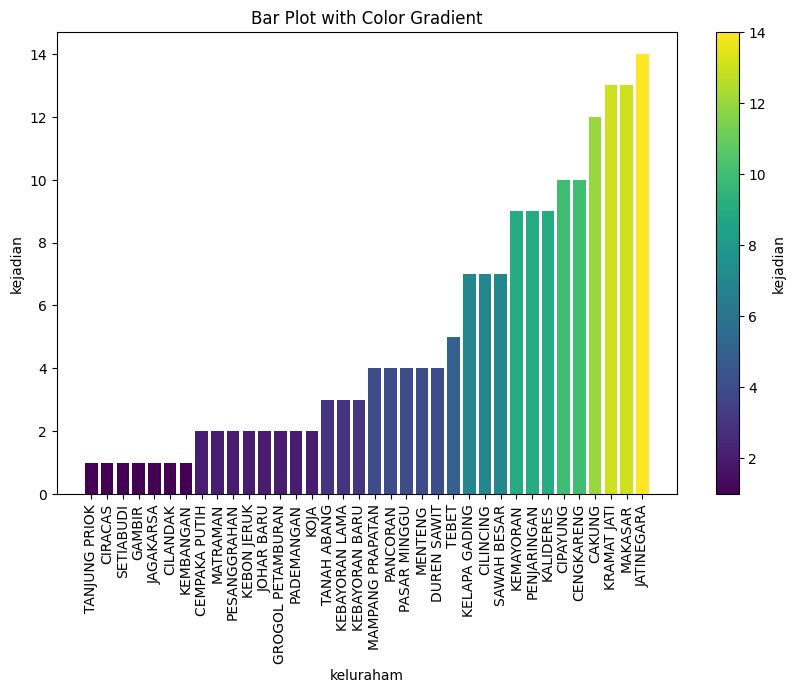

In [83]:
printBarPlot(kasus_banjir_per_bulan_kecamatan[1])